# Task 

You have a data set with 133 dog breeds.
Build a neural network classifier that can learn how to classify 133 dog breeds.


1. Preprocess Data
2. Define neural network architecture
3. Use some of the layers you have already learned in order to build your model:
 * Dense layer
 * Convolutional layer
 * Batch Normalization
 * Dropout
 * Min/max/avg Pooling
 * Global Min/max/avg Pooling
 * Flatten
  
4. Use some the techniques you have already learned in order to train your model
* augmentation
* model checkpoint
* learning rate decay callback 
* early stoping
* transfer learning

5. Evaluate the model 







# Download data

In [0]:
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip

--2020-06-09 20:13:25--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.112.216
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.112.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  21.2MB/s    in 52s     

2020-06-09 20:14:17 (20.7 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]



# Unzip Data

In [0]:
!unzip -q dogImages.zip
print("Data is unzipped")

Data is unzipped


# Read data

* (train/test/valid)_files : list of image directory locations in folder
* (train/test/valid)_targets : one-hot encoding based on folder names
* class_names : list of folder names

In [0]:
from sklearn.datasets import load_files  
import numpy as np
from keras.utils import np_utils


# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    class_names = data['target_names']
    return dog_files, dog_targets, class_names

# load train, test, and validation datasets
train_files, train_targets, class_names = load_dataset('dogImages/train')
valid_files, valid_targets, _ = load_dataset('dogImages/valid')
test_files, test_targets, _ = load_dataset('dogImages/test')

Using TensorFlow backend.


# Remove the numbering of class_names
001.Affenpinscher -> is converted to Affenpinscher

In [0]:
class_names_processed = list(map(lambda x : x[4:], class_names))

# Implement load_image method

* Read Image
* Preprocess Image
  * Resize
  * Preprocess_input

In [0]:
import cv2
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
#from keras.applications.resnet50 import preprocess_input

def load_image(path):
  # READ AND PREPROCESS IMAGE HERE
  image = cv2.imread(path).astype(np.float32)
    # preprcessing
  image = cv2.resize(image, (224, 224))
  image/=255.0
  return image

def load_dataset(files):
  vector = []
  for file in files:
    vector.append(load_image(file))
  return np.array(vector)


train_X = load_dataset(train_files)
test_X = load_dataset(test_files)
val_test_X = load_dataset(valid_files)


# Visualize preprocess Data 
  * Don't expect natural picture visualizaiton because files are preprocessed

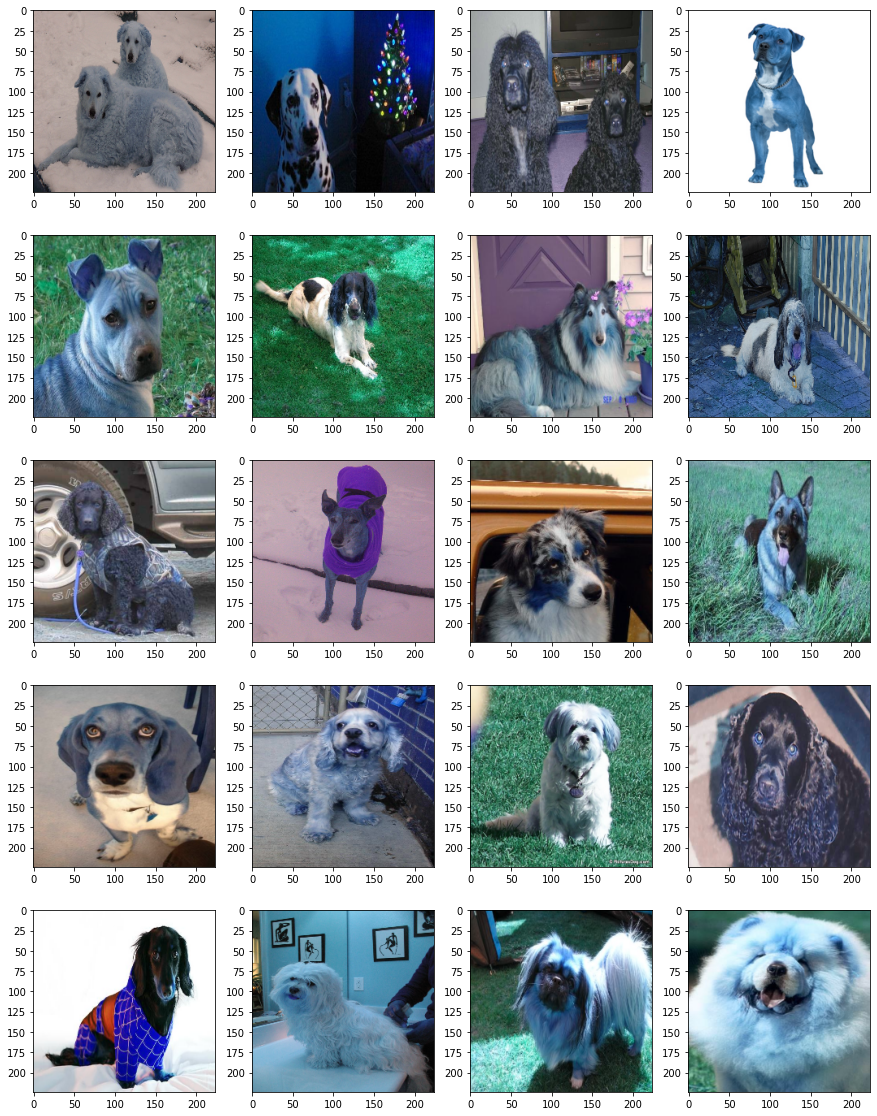

In [0]:
import matplotlib.pyplot as plt
#fig = plt.figure(figsize=(10,10))
#test = cv2.cvtColor(test_X[12].astype(np.float32), cv2.COLOR_BGR2RGB)
#plt.imshow(test.squeeze())

fig = plt.figure(figsize=(15,20))
for i in range(5*4):
    # dodavanje na podgrafik
    ax1 = fig.add_subplot(5,4,(i+1))
    # crtanje na podgrafikot
    ax1.imshow(train_X[i], cmap='gray')


In [0]:
broj_na_klasi = 133 # broj na klasi

# Create your model architecture

In [0]:
from keras.preprocessing.image import ImageDataGenerator

#Declaring the Class For Image Augmentation Process(Options are Parameters)
train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

#Generating the Image From Fectures Declared
train_generator = train_datagen.flow(train_X, 
                                 train_targets,
                                 batch_size=32)


valid_datagen = ImageDataGenerator()

valid_generator = valid_datagen.flow(val_test_X, 
                                     valid_targets, 
                                     batch_size=32)

In [0]:
from keras.applications.xception import Xception
from keras.applications.densenet import DenseNet169
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Dense, Activation, Conv2D, Flatten, MaxPooling2D, AveragePooling2D, Dropout, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization

model = Xception(weights='imagenet', include_top=False)

for layer in model.layers:
    layer.trainable = False

layer = model.output
layer = BatchNormalization()(layer)
layer = GlobalAveragePooling2D()(layer)
# let's add a fully-connected layer
layer = Dropout(0.5)(layer)
layer = Dense(1024, activation='relu')(layer)
layer = Dropout(0.5)(layer)

predictions = Dense(133, activation='softmax')(layer)
# this is the model we will train
model = Model(inputs=model.input, outputs=predictions)



# Print summary of your model

In [0]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

# Compile your model

In [0]:
# COMPILE YOUR MODEL HERE
from keras.optimizers import Adam, SGD, RMSprop
optimizer = RMSprop(lr=0.001, rho=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=["accuracy"])

# Train your model here

In [0]:
# FIT YOUR MODEL HERE
import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing.image import ImageDataGenerator

# Спецификација на аугментација
datagen = ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,  # randomly flip images
        )

valid_datagen = ImageDataGenerator()

# Го зачувуваме моделот со најдобра вредност на валидација во текот на тренирањето
checkpoint = ModelCheckpoint('best_model.pt', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
epochs = 15
learning_rate = 0.01

hist = model.fit_generator(datagen.flow(train_X, 
                                 train_targets,
                                 batch_size=32),                           
                           epochs=epochs, 
                           callbacks=[checkpoint],
                           validation_data=valid_datagen.flow(val_test_X, 
                                     valid_targets, batch_size = 32))

Epoch 1/15
209/209 [==============================] - 96s 458ms/step - loss: 2.7545 - accuracy: 0.3668 - val_loss: 0.0160 - val_accuracy: 0.6587

Epoch 00001: val_accuracy improved from -inf to 0.65868, saving model to best_model.pt
Epoch 2/15
209/209 [==============================] - 94s 450ms/step - loss: 1.7580 - accuracy: 0.5585 - val_loss: 0.1016 - val_accuracy: 0.6862

Epoch 00002: val_accuracy improved from 0.65868 to 0.68623, saving model to best_model.pt
Epoch 3/15
209/209 [==============================] - 94s 450ms/step - loss: 1.6093 - accuracy: 0.5907 - val_loss: 0.0567 - val_accuracy: 0.6898

Epoch 00003: val_accuracy improved from 0.68623 to 0.68982, saving model to best_model.pt
Epoch 4/15
209/209 [==============================] - 94s 450ms/step - loss: 1.4648 - accuracy: 0.6322 - val_loss: 0.3074 - val_accuracy: 0.7006

Epoch 00004: val_accuracy improved from 0.68982 to 0.70060, saving model to best_model.pt
Epoch 5/15
209/209 [==============================] - 94s 4

# Load Best Model

In [0]:
# LOAD YOUR MODEL HERE
from keras.models import load_model
model = load_model('best_model.pt')


# Evaluate Model

In [0]:
# EVALUATE YOUR MODEL HERE
score = model.evaluate(test_X, test_targets)
print('Test accuracy: ', score[1])

836/836 [==============================] - 12s 15ms/step
Test accuracy:  0.7033492922782898


In [0]:
def get_prediction(image):
    image = np.expand_dims(image, axis=0)
    
    # istreniraniot model go koristime za prepoznavanje
    prediction = model.predict(image)
    # prepoznaenata klasa ni e indeksot od najgolemata vrednost vo izlezot (prediction), najgolemata verojatnost
    predicted_class = np.argmax(prediction)
    return class_names_processed[predicted_class]

In [0]:
import urllib.request
import cv2

def url_to_image(url):
  resp = urllib.request.urlopen(url)
  image = np.asarray(bytearray(resp.read()), dtype="uint8")
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  image_ = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # PREPROCESS YOUR INPUT
  #image_preprocessed = ...
  image_preprocessed  = cv2.resize(image_, (224,224))
  
  return image_preprocessed, image_

def predict_url(url):
  image_resized, image = url_to_image(url)
  predicted_class = get_prediction(image_resized)
  plt.imshow(image)
  plt.title("Предвидено : " + predicted_class)

# Your model should produce outputs :

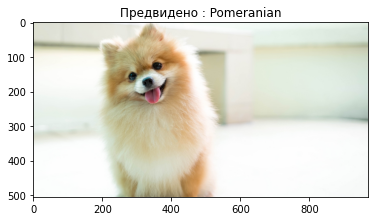

In [0]:
predict_url("https://d17fnq9dkz9hgj.cloudfront.net/uploads/2018/04/Pomeranian_02.jpg")

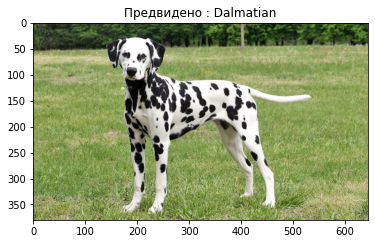

In [0]:
predict_url("https://vetstreet.brightspotcdn.com/dims4/default/743d415/2147483647/crop/0x0%2B0%2B0/resize/645x380/quality/90/?url=https%3A%2F%2Fvetstreet-brightspot.s3.amazonaws.com%2Fee%2F140380a73111e0a0d50050568d634f%2Ffile%2FDalmatian-2-645mk062311.jpg")

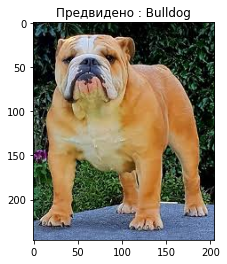

In [0]:
predict_url("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUTExMWFhUXGRsaGBgXGB8YGBoeGhgYGh0XGRoYHiggGBolGxgYITEhJSkrLi4uGB8zODMtNygtLisBCgoKDg0OGxAQGzAlICYtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIAPYAzQMBIgACEQEDEQH/xAAcAAACAgMBAQAAAAAAAAAAAAAEBQMGAQIHAAj/xABAEAACAQMDAgMGAwYFBAEFAQABAhEAAyEEEjFBUQUiYQYTMnGBkaGx8BQjQlLB0QczYnLhgpKi8WMVJEOToyX/xAAaAQACAwEBAAAAAAAAAAAAAAADBAECBQAG/8QAJxEAAgICAwACAQQDAQAAAAAAAAECEQMhBBIxIkFREzNhgQUjcTL/2gAMAwEAAhEDEQA/AOY+D6Brlx7fvCLeNxAncvxDkQDgZMRnnipLiAXWFlT5Z8xlrjmOc/DmIAj17Bj7P7U0r3GuAIzEssyRtxtjqzflQqeLzae9CzbbaEmGAeCCT14I+lEcV1Fu03J0Knt7v3lstCwCDl4EgN5REQFB9adeA6E/v7lwAsqkpMMZgknHzHHrUHsnqLZV0wjbT/FEg9jzuBoO3qmtXGsKwKswUsB5nUx5ZPEzE9JNVpKmWfZtojZz7oMZIa4zEmCYVVnnrmYiOKisXQfiTBxKnaR9J2zxiBPemnjWjKuls8uXwPhWZBCjoJI/ClNrT3cMAf5SOojG0jqKE9el18loI1+hQLuBMkDYVko/eZMo8GY4BB9KX2k5zBAJzxAB/HiKu/hXs3q2Tb+yX2VsiEYFSOq7hB/XNB6v/D7xTcW/ZrsGc4HJJiN09ePpUdkSoT8oqulAJYvuhRMDqTxJ6CpLMuRubykyY6GMA/IdKtdr2E8RcXVGkv8Amg5AAMHGT9etCn/D/wATTcBpXzjDWz9wHq1k9JCnwHL3c/CpbntI/qKB06TK7ip9ePkRTHU+yWvsSbmlvLGCfdsR85AI+s0qvakscjMRI64gH51Cq9EOEkwdiQefxqVrjLnccgiQe+DWHslQrchs/YkEVrJI2gYJnjsDwe1WLEe496ktIS20kg1oVzBrNwHk8nP/ADUkhTXSQCG88kHpgjBod0Yc/nP5UXasAr0B5IJAJ+U8wBWL1vKkq0QJj1GIniosonQI1xoA/WaY+GWgdyNK3OVmYJAnawqC3aQSGMgcsokA9DnkTisWro3AszSAIPPHGegqGdLaJrmndgWkhEmAW4kk7R3Ehs+lDuQyAiQywCO4jkR2I/GmvhWutKx3EkbWGREQGYif9RMdOk0vLiS0593+MbQPoPyqUQm/s9aDMPdTIncAJMHbyI5mcj0oeyzK42knOCJn6RmtdJqWtsHUwRH4Gf6U88Fv2rae8c7ZaFHO6JzETAn71xMm0SPrCmnKquWI/eE7dnHlTMl8x8vnTW77nTqov22uXWyxB2qDjyiCJ59fxpAANTcB3YG5mXghVOAOhJkfjTjQaNb6k3r0MGI8zDiBAAPH5yTNQlSASWkiu30hNwLAEkdlPqMz2xHWlxplqdKyopuE5yik8AgHcew9KCtWS3r/AH7VdeDCaI1npV89j/Ze3futcvu5S0qGEYBndi5HmIMAbGMx2qj3F2tnERxnoPxrp/sNbm2VSC10qNwPQKSJ+RZ59ZoeaVLQXFHtNFq0Hsho9Qy3/fXyirAQhQFLRI3FZZjAkhcAVbNLZ01ldmntjyYLA7BPZ73xsRiQCe0dldtQipbSQqCPt1+ZNaHVJvCucDA3SUHHlVfhJ7seppJXKVsacUlod6Mbjudy5HRZC/0JNE6myjoVYGDt4JB+IdaE02pQeUdMdo+1FOfzH4MD/StSCio0IzcnKyDWvtUIh2kzzJgDmPWSM+tKv2Ujg3GH8sK4/wDIz+NNNam4qO0knsKD1N+0uJI+X/NK8hdn/CGMEuq/k9p7oGQSIPygnieopVq/ZvRm618ae0LzZLOm9CerC2ZQOeZjP1JqZPEAXKmH2gebAcA9D0K+nFHEAjB3D9YPalezXgzS+yseL3tKPI1nTXC3Q6e2onuSAT+NV/xrSaI7VOmtAMJ/dqEaP9LDg9vxBph494IzahQCQh8325qu+LAi8DMiIHpGI+f96Gpyv0I4QopHjPh5s3XSSVU+Vu4YBlJ7EqRj50KmnZpjMCeenbP2+lO/bFzvtmebQB/6blwCfoBSH3JO0jhjAJ4nE/mPvWlF2rMuSp0HWr7sbm3O7liIKgRnsMYojw+0wt/CHF0jaGMA+7Mtz6GOZzWuiB9wybgAXgiM8DLRkjoPUmtL1tQiruCmJzO3/dOdpwO88dKkGzaxpTbuKr4LSIInBlTPpFbm2oO28vmXmIGOxIOTHy7dcaanXvKG6CzplWgeYSCM/wAQBBz9Kiu65bm9mG0ncwiSCSSYPbmJFVaZFSJNNpAzHEcQBA7wRvMGYGJnnms6vSIqrb2kX5O4yYmJ2ERkzGR3+VbeIaQlFayd1u2FBI580t5h0yWGeDPpWhtX4ts8DYBs3jO0npHQTME4nFSjl/0A0jKCd67gRHJBHqCOo9ek0x8QKvdZ2yDt+EkBYjcIKicSB/Witb4jZUBbVqcklnM7i0BiEMhfTrxQmp2qXDfEmIGQTIBhoiAZ59Oaht/RDk3tE/gWjG5L0oQnndSZYKG2mQOuQR9DQZ0zuzNGCceokicdMc9YovUaJG03v7TlSPK9s8yxAMEcjjBpsbsQuntSIBYIpME9Gxzg1z8KuVbEOo0zMoK5EGIyTtMMfyMdqG8N0xdsEAjIB6xTbTqDcS3busOCpT+Z4ZxIyI2xB7GhGuPYvZQMZMyIDTzEcSCD9aJH+S96pAGt1DOxLABszAjM9fyrr3+Hem26e00R5PKe5YyT+MT61yzxPYwR0nc07x2PAH1An1k12L2TsN+waWcH3YP0JYr/AOJBoHJfxG+Ntja9rlWQWiBJqo+Ie0ltrxVCGJgCDiZwPuRS72o0OqLEFzsaCdgztnPmPXrHHHzqz/4Y+ytvTIt91D6hgWt7h/lIeGjMOwg7swCAOWmmPAnVsJPLT8LR4N4dcCKWkYyz+UfQfER6xHrTnaMS4kdlmfxqu+0vtEmnQs77mOFUNkn59B6/1xXKdd7SX72oAa6Su1iwEqEgGIHHO2nMeOKFZybO6Xrc8OM9wR+U1Sva/Q3gNwUjbncp3L/1RkD1IFUDw/2iv27yxf2LsVgrNCsT3UmDnsK6j7P+NjUqMwwwR2PUHP6GetD5GJNaL4cji9nOLftVtdmZH/dgK8DgknDfb86sPgftSrum0jaRB/qP12rT/ED2Rt3A1+2nu71sAuo4dON0RAZRmQIKg9qQezfs0HLNBXb8Md/ryAIHrWflxwUe32PY5ybr6Oma4BvpH2bH6+VUL2g8N90pKtKo+QcEF+GPcHAn+9XHQTtG7lf3b+qE4b6MRj/X6VVPbo3DbDYCtdFtyeFe2CFDehz9UoUPlJF5/CLspGvD3bkLEKsSYgMZbt6xVfNoiQRxP4c02a2928baKEliD12xkyw9Zj5xUOstvauRcllG7buwDys84yBPyrUjpUZLbbbNdCoRdzKG3NAE5gHJgcHoCfX51Lr9QpuHdmDHlwoAkbQP6/nQFtionpwM0X4DpRcujcJVZJwSvoGI+EE9TXPZVq3Z7eHTYWJVSfdhjG2Tn0WQPlNRpYggbSSZ8p6gSSQfl+VF6UKC1wpuZSGEsFVeokczI+GttPqpMjYEAM7wApcjoBncBxmZAMiahM5MI8N8Ts27T20W4TcABjuD8S5nI/hI560HqvES6FAUOS27bteNxhZ64MgD+lFwVusbsKwbZDkhzuJG8G3G7ackjuMEGhP2YLcPlYBDGcMSDBgRjMwCD2Ndf5K6u2a+FWYcByJwQpDMGDEqwhJIMEmOcY6SbpvC9yXGkOASu4cNwdwnoQOves37FywAboAbYy2wDFxdxJm5t7AsP+oDpgPwnxZrANuQVZ1LAyR5T0Iyp9fSuasiScv/ACbXWbThrcbkcIzD+Vo3LtYfCwDfjW/h1i5dBa1ZuXmnzEywH8okcnmfpUup0Qv7hpSDbL7mViFKE+UZPxJkwRmOQKjv6T9nhLl1X7BAXC9T8e0AmQcTU/RZO1X2KuCIOfTEZP48ZplbLXVB+JkQgH1Y+UHuQJ+1JicmiDqW2e7GBMnvIBGfTPFWLtE3h2rADI0jcMMvxKRMHHIMwRXffZ7TldHp1PIsWp//AFr/AHr53098o25TByJ+Ygx9DX0f4Te3aSw/81i033toaFmjoLjdMB19kMQp4J57Dk/hNP8ATWfIJxuhmHEyMKT0VFgR1M96U6i0SsiNxG1e25/KJ9M/jTbxDULbR2J8iKSe+1RP3MfcgdK7iR02y+eVtJFW9qLwLizZl2RC1yFAKgDcWLcKNvaOg9KomruWyDumIM+aOn40X4r45e1bEs5W2uAFEL8lH8TD+ZpifpQVi+qfDbRiGDbriLcYFWUjLLgSBIEA5kZp9OkLNbMeHQVQgwdq85AkA4n510D2b8PstLi2FePOUwczF22RBBBBleueYqoaXwe7qkN2wlsMCQdsWgzEk7SDgnIMgwN0dIDX2G8QK3mtMWS8shbZHxMuWt9CrwJXMHtxNZzg1RKhJbL1qrLFCHIfYpZHGNyx57br0wCcYOOJIpJ4fY92do46GrKArYyA3GIgkfCR0BGQPn2pYNKYHcY+oHH67GsnlYm2mh/j5Uk0zHugXAPw3FKt9cT+M/SsaA5uqwjc24jkSVUz9zUt4R7vv5vw2mhku/vnjsp+uR+QWgV1YVNyD11DJjiOIwI+VbtqpEGCCOoBH364gVqhDYP0oa/bA5+8YPzHfrNMrLRT9NMjbSafcH/Z7G4fxe5SY9DFFe+WMMw9FMfUDjvjHTmgDzBP6/rWXHXg/rPp86iWS0SsSRB4/wCAWtWu28gcxC3R/mWyepBjcMCRJn0rlvi3stet6h7V5rfukXcrxtVlgnyhRIJ4PqM8V1mzqzOST6n+pNR+O+GrqrexiJBlZEjkEox5CNAnb+PFdjyUwWfC3HXpw3xS6Hh2M3H6jJwAgkdCSp/PrU+ovKbCbi3vydhGTPZ2ZjjkiP8ATOKb+NeGtave9vpHme0YthRaKopVhbUw4CsGUyd09CsHQaALaF1Vt39zAKu/d5oY5trhiBkgkRnHSmPTNlppNCrWXC173Vr96QYkid2zJjrB2kk9qg1HhwZHuqQoDZUmcM0AIf4onjmM1I1uQXCgkMPNaAUCRBXZ/GD9ODkzU+qR20+4C29tmgQDuVokfDABjvMycHmrfeifGqI/CLwttcQsNokoPL5nwign+XMnpANMNZYFu4QbaXCVUn3kuQTJJxAUmRgTwM1XNHd2OHKBsgjcJGGGc4IkQab67xVnYxeCeZiQqlTJPJKzOAoAnAEdyekvwRKD7aFItOjtA+ElSYkZnGe4mtDbYxiZxgTMRwBTm/rwyi2ltcEb3Il3I5LEcCJwO1MtPYPuw7KQbcARtUkL5jtZucTieM+lTZftYkXw+1taC5cEAbxtUyeYIlY9TmenXsXsLrWueHorf5lke5Yf7cp//Nk+1ckUB2Yq+1gTtW5MnOACBDNxj7TXZPZ7SfslpLE8LDHvcOW/8pA9AooWSX5DYk3bQyuvFyymMOn/AI+dj8gFJqp/4leJvuTTIY3BS2P4i0KPXbE/X0q0aDzOLh6KB38xIn8AR9a55qmN7xNesNuz2H6FFXxxnLcy0WvANMF2BW2IEG3dgkCdx6yTJOepqv67wVv2r9xb91tHJ+BiyvhMEARjb0zNXEvtYjkMoPpK/wDDc+lBeJXMIwyA6nHYnafptYmlnna+x+GOMvo38Fs3EsBLgUMA3wcDJ2zAAmImO1KvH/D/AH13S3lIR2IQtkcAuhkZ3AjaP9w7U805PBME5/XagfFtL7zTFRzGIxBEEEdjIoSy/IvNx8LL4WXNq37whrgQK8GQ0ZiT1/iB7z6V69f2sQZiT9iZHy/4NIfYrxBr1qbjkuha23GTKurn/UAxWeuaf+KWSQr87T5sxKnJP0P501JtxsR6pSoj1jwsnO14nuCpgx34pANX+/udQCq/9qgH/wAppvomZwgbidzH0HH51XfDQCS/85Lf9xn+tZeee7NDjx0yx6a7manuXvL37f2mgbYI4ra03SpjktUS4bsiuiD6Hj09Knt8dPl/StrtqVI+o+dDae6Rjr2NEjL8nNaIrvxCiUun5VBeMwYH6/XNa+87VTt1ZbraI/ajwgaq17xUDX7QO0R/mKVbdZacGQSV7N8zXKXNu1+ztZI3MjBgfillK+8IHJgsBPWux6e8QRH69a5h/iH4EbGrGotBRbf97B6MGHvBHUbmBjmGFO4ciaozuVhr5CLw7TXbKm4HNsEwrc5BG7A6cj5iodL4s+nbyhdjGWAxuB5SRkCZgfwnIptb9o1NolrKtDi5E+Wd25lIJwpgcfzGkSaMh5ugKDkgiCNwMEA/rimP+iEb33B21cs5id3G47mGZ5PXpNMdH4b5Q24MWEmM7f8ASZiGHUZ5Fes6K3DFCxAxvZSFUt5RkH14PpUmhs7AQzMRMr0ESRMHvH4VWb1omclWifSeBbbjb2YhZZ/dqSyoCZckwqjykSWEHviYLbXHvPecMQEdsNBRSGCiTJB83HOZpyfG0m4jEqXtEHJYMHXeFO4zOFI/3kUo0/itwIdPC+7uYJyxWTiJPljjtAHaiUW3bLB4P4QD4npyVBRyHGZg213lvUHaM+tdMv2Zn1qhf4e6YpcBJ8iJgcwzBQxBIwDDY44710V+KS5Ek5aHOMqgVfxbxz9nDKf4iSCevE57/wB6qfs94itzxD3jGJUweAT5cfYE/Srf4/YVrZVvhMyPvSLwL2St3Gdg5AQLA2iTuLdZ6be3WujnTj1ZeWLq+yLTqteoYFSGI5AzE9JHWPrWVZWDDMcgdu/y+XzrTTeHoihAIA49TznuetZCwRtOaRctlvPAhiAMA8QD/eh9PePwwIz15NT6liVz0zS5be8xFSmQD+Ev+y37m8xbuFSCR/EMTjoQ34Cra2tV0hMkggZkCR1/Ckum8M3FBcLOEPlDcDM5j4j85p4FC8Uws7So5xT9AfGLnutM4BhmGwHr5sE46hN34Us0SSF+VEa+97x9vRfx9aj0421n5J9pfwP4Y9Yhd27twDmpNNgUHbMt6Cit1TGf2WaC1uUBrEhsY6g1OjVprh5Z6iixlZSqYNeOSO4DD6yCPuDUatWC24fLP35/p9qiskk1XIwmNaDbdw0L7U+F/teluWR/mAb7X+4fw/JhK/btW60XpXP2omDI0weaCaOD6q4ExbB2ZEssbjBBn78dMVvYUqtsk7i5IVVJkQQAWwZ6wKsf+JHg729Q9xAfcuRd58qtckN5f9y/lQPh3hh2C6GDtMW4PRCNzEfYZrYi+ytGDkfTTNNT4bcX3aORYQkAhnBiQAWaOOuDgT0rGqcWTsgbgIYEQcElWM4kqw4JmJNSeP6pLl4ruLSwWQCNoDZYiPNuEkAcCKM1Wm0/lJNy4ANg33FV1CkwGAEj4sT0+VRKgV+djfx3w9Bad2gupgBV2lkILB2cTDA7lKmZG3oKS2fFrgRnJBUuIWAJMAsZj+UAfNpp+dIfd3k90SBbXzyXKF03xtbIUJuwBj3fPNB+H+DK93TIm4pgkmMkgFyMfDAaPSM1ZtJWw0N6OkeF6b3YGInJByRIG1STyVWAfUGnaZFDm31+tbq8VkOVu2a3VJJIV+MaUEGB9aX+zLm1fKkYuIV+qkMPwDferFdthqA1GiEgjkZ+VCUmmWauNMM1Q3RGMzNB7CHz8waJOrAWWGfz+VReF3muEll2zwOwBx9f7113IC06N7iSOtY0FoAmmB08ioxpyDREqYHbJ7BrF9pryWa3upXT2i6F5gyRzQd81JrWg4NDA+tIyezQxLVhtkYFSj0oTT0baFWiWejxUisX+BUl2g7lzpRIuivpDp7fmYdpH5VBpT3ovT/5vowA/pQdlIEdqtk8TLwe2EsKktEjpH0/rQ6uT1rYtFVhKmTJWV7/ABRf/wC1tmTBubSfpvAP1Umue+H6w6d93KPAdI+NDkgEjB/vXUfaax77SXBsDlIuBTMHbuDcEZ2sSPlXKdWCVksdqAC2p+LzQenSMz6iK2ONPtAxOXCslfk0s3kDOG37ZJSIJBnG4nPw0VrNSobaAt1QBDHcZnJPQzwDM/DSpJ6VcfZfR2LlrzgF1gEsdo6wqwfNHUnv6Ud1YpNqPyYQly7aFy0TJ1AKXSP4diq6mQTEe9URg5zkVH4Dq0tLYN0y51CLbA4VQPjmZjzrgjiOCKxqbgDAqVNsKbiWr4I3IWiAbY2s08HEjpmCo8YaXsBV2AZUdiWkDgcDb9xUVaovjezuFqCKivaeovCdRuUHvn75poQDWZ+n2RpufVilQRRFmDRFy1NDC2VMigdGmX7JonbSAjNY02mO4dBEUTaef61lWMjFNxxK0xaU3TRIbdYFupN2Oa1FyiSgikWeUVq6VlpI/U1GzE1TqkWbE/iVsTgSahtaY9aZHT9Sc9//AHW4WkJ4vkOY8r60C2rNTkRUnHatWaa7qki3dtgupaBQKmeKL1IpUcGg3sYitBYbzKex/qP7VrfWCw/1H8zUVtpYfMUa9uST6mjuLlHRXsoy2Li1atcqW5YMmtbtrFBQbRLpULgpMblZZHTcCs/Qma47c4AK7duDkkyMRJnPSOlde0hg1y32rRrepv2gCR753XE/5kEED/btrT4Lu4mV/kcd9WKrlkqcQQcwJkZIyCB96beG61bYKsYJg8Tz3jg/3rHhmkJB3tHCpMnI8xCwdsjsYEN3qwpotCAC5IBEqCMnoWO2cn1PSKelsycjj4yO4DcS2zjYQgTI4KkxK+rKMCly3Fvapi873uEAKAqCBBYRgHcoxEQaLVB7q0d0Irue0/vXgEnpkE4ztpPqVCtcCENAMYzLsu4EjykAA5GM1ZPYSNXR1j2VvhtPaYT8IGRB8vlMjoZBqzIwIql+wlsjSWpPO5v+52P9RVttEdaz1KpNGlkjcUyXao5kfiK2VkjnPrQl672oF9aBzXLNCL2gTxSatMeNaishhSvT6hTkGJ/XFFbfU00mn4Adr0JCCCZx2rAuKOhqFLgWd07fTJ5H9JrZGkSKpLTLIm97PHFe2cnoKhNRtHU1WyxJee31bPYAk/gIjj70Kz+mPWodTen4YqP3h+tJ5ZrsM4ougyKw9QLq+4mtxfnpQm0GSYLqTSu82aZ6jM0uupFL/Y3DwzpTkfOjNNc5NIvEdabNt35YL5QOWZjCj5ZrTwHxFiql1KHgjsesR0PNaGGDcLEs+SKmo/ZZ2QUNqUniirbggfnWHSl8kaD45C8Woqke21qNSLoBXfaQFhMBl3JyOJVV/Guhv2qi+2thTdtBmC+U5J8pG7AmIUzJk+nai8P/AN/0A/yG8P8AZX9ApuMf3mxVDHzEtkKAW2zkCZGMn0E0Lo9X5nJVmkg/FBGI8xgyYA/Gi9PplsnUG4Q7GzKOpBXJAMAHMgxjjNN/ZHwr/wC3W7tDNdLEnnAJUL85DH/qrWq1RhyklHfhk3r9ttqBAjkhGAlknexCsRNt4kGO3JiaA12ruP8AtVu6gVmUboXaYtkMN38xjbnt6VuviFxLb3fdqLj3Q/mQkAeYbAJAECGmODzyKO8IWw1sswe5fuq6KmSASnuw7GfUnOcdabWaCSS8NJZsUYrWi8+zWnVNLYUAgC2nPMlQxn1kmmjXgB1oHwQ/u0GcKvOD8I5B4NH3EEV56bdtjaSaQFrL0qYwelJnRoO6nd5aXeJW22kLzQLtlqSQFY090xtcgCrPo/hEmuc6L2kuI7ae7CsCQHJgNHX0JjHQ0z8G9pyC3vI2ho3A9JIDAEDy4+kitDFGWN/IzsuWEvGXokERXrJgZwRQCXwwBBweK2uOSIPQ4PpHBokpfZEQxrgqDU2SwxUCGpw5HWgvZdaFhtMta/tAODg9v7Ubrr0CZ4qua/xS2QQwII4IpWUdjUJWh8iRwdx6j+3rUpuGMYpZ4HrhdQPORg/P1/XWnhsg5qsoMLGSsEC1C60XeIHSgrt00BKmMx2UX2u1DDUyf8q0f4cncFCyRMwMf92eaR+H+Nsm+5tL7gIJG0SpMLP8oBJgdYpz7WgjVXZ8itcAYk7laFSGKgjAEDJ5mli6U27m1yHG6D0VvMw8rdJjgGa3caSgkeezTvI5fZ0LwnWSFgyrCVPX5H1HBp2Celc89kNazPfQiFFxjbGAUI5SBxKifmjdzV+0lyQOaU5GOjQ42SyLUAzVM9vr0oqcsyHbLQPK4JIzkwOPWrzqlxXOv8RL6Bbaf/k+Ieg3EfckH7ULh/uhuZvD/aKPeOSAxPbP3ph4N4ldtqyo5AJmASMxE4+Q+1D6O00MRb3TAnPlOD078Zra7oWQgghgwDeXpM4M8Gtcx5U/iXDxLWCzsUWAzhTh2JUBm9AN5ME9OPWoLevAS67WlRWVl2qMZEAgQOc44krWniRVgpD7mcYyCYCyQY7EjHQ4xQWj8QZka0VVoVtsz0UnaR1wKWFYx14dI9l9Qr2k2vvABG7iY4kdDBGOlP2rm3+HGrhrlrcYKq6g/wCk7WieJ3qY/wBNdJtmRSOaPWTRv8eXbGmQoJNR64eXAzRVu1k0D44Ys3TMQjEH1Ck0OMS836c00d472c7BfRi9wsY2CWUhdxgjKgyQAAeaLe8ssBbjyljtXfwVyqlZUBsmJEA477aLUsTb3uGIC7maciIBUH4Z8pIzMTgwKDu3b0FyJO2G+R3fFAnImeCJHUitGStmFLbsa+A+MGxKOyvbxjdLZxOevf1nHQWG14iriUYEdp49COhqk7luuPdwPIEaWO1YC/DccS05XOfMYwajuDcxC3FkMZYDMRlfKIMCWJ7/ACqriFjla9L3a18MBjJj+3/ujF1azAYMM5GR9DVAsalbhTc9xQwIeDtVYVicmSZUHIEAjmo7HiO11O24h2yFJ3kgrKttAUspA+LPU5iq9Gy8c+/C9eKXAVyaqPiDzxmnekHvID8EKwE9GUEfWDFMf/pdgsG92Ay5BBIE9CQDDfWaWdKWzTin1oA9kNO4t3NykeZSJBEgqciRkYGatyZUfKllvUkvZQ/x+8Q/NFDj/wAdw+lMgsLHaamS1Z0faBtQaBuGiNQaFtiWFIv0eivic/8Aai8qeJ6pWUuCxBX6LhY6kASY7j1r2kS5eVAWKqrsqsm0yg/h2cLGAGJJ6RiaYeKWv/8AZ1V0AsEJ6lfNsQMNyjHLCDHzrXw9IDhStsb1CAEtKQ26AT2HccgyBFb9pUjzeV/J16J/DfFHF1Ll3cvmUE7slrZ4cYBklgRHU+tdRsNtdkPQkfY1yzQX9Tau3La2v3THe4uqCNjTJLdVIM4JmARMV1Bh7yH/AIoBIPPmAP3zQOStDXEtSZPrHJFcr9sVK64i421PdrtYjcPg3EQP/kJHpM10648iBya59/ijYdHtmR7u6oIEfxW8H1BhlOOd3pS3C/dY7zV/rRWfENUBG33ZBO4hQwEr5dpk+YHaGx36cVhPE5Zm92iz/CshR6AGYFLQ2Io7wu2pDSyjj4o/Ca1qMppVseeEpL5IXbcOWMLDsnWMAe7bPqPWo9HaAubRO5ZPGIUmc9RHbmafWPD7KTCE7mlpIOMQIA6GIzzJoNrZLF2uJsK5jysgmVAcAzcDSIjqRxFLy36LKSkG+zNoJfVo5DIMRmJIP0WPmRXQ0u4rm2la4l2zDhhcuKSeVJDQQC6qQdvBiSUOTJq/2eBSHIVNGxwNwa/kY2WpL7XsV07sWKqCu7bhiN6ghT0aCe3FMLD5qte3epn3VskwxLQADO0QFO4EAEseh44zVcK7SSCcn4wZV38QN2IG5BBAI8/nBgWwwlmAxMHMZzNbauA20GQQCHAAMHEHrjYeSDMzJmsJaCuNRsvAODtQeeQV2zPKKAwIXaTkREAVpeS2E2pDEAqWJO4btrBBHxRvnIOQQcTTzS+jFa/BJbQKyhydreYqQVccqGE4UiT6RmMVFqNSqliATbUDaq43K8SNw4dpUlhJBLdKnOsQPnCpsM4ldhnbzkAdMTuPoaH1ZUFkk3C+4otte/FxoPmJ80iODMmAaiJ2wvTWdO+4Kp3wNhI3jaDA2KBDDbyxAHm5waLS6bdu2rsgYSAXKbfdmfL8J2qGExujmIpTdvscsnvQoCttueVtzBnZtvx5KgA48oJHStdO6lwACxe4FUkk7LclBwfKMgR1xXNMiiz21IS228PiNyxErAjBOY29e1HWrrTNVjwu9dtXHsOf3YEpwJKkKrLESSsg8/D6VYtKoYT/AFpLNGpG/wAWXbGrDX3KbV052X7c/wC27Nlj97iU8vvE0s0NveNsxEY7gEH74o2+1dJ/60dGP+xgepevaC3LCepA+5qDUXKN0nEnpmk47kOS1EoXiqBr+9iEBN92IBh91246hmXzCA8FgMRHQVFoNVauDatq0rBYYXJ9x8JzuJJAwYJyD3oY3bm+4CT5vhTbulckMNsmeDgjLGcmoNTqGWFZmZRwA2yO0tE4O0yecittW0eXltjLSI40y2W3AspUFgGVlBWSFUlhG6ACYeeOlWPT6zcLbDynaFYc/CApk95WqZduE3GuvbtkhfhYgSF3DdKjzbevUgRVl8CQ/s6AFWKs0lR6KYye5J754FDzL42N8N/MsFi+ScffrVO/xavbhp84BubftbB/GrPbaB+ppZ7Q6W3cFo3UY29zJCglpm26gRnzBLo/tzSvFaWU0+V+02cmipLPWmGq8LNuXujYpYhFVg5aDkKQSCo4LTEgjJmCbV/3JKJtWMMzLuLEc/IAyMdjWyZBbrzpbUbWMlgFYMGUFuFDSNoIII5gEHApbe1rBjbYQCR5Ttd1IABcMuQJxjBAHPUkaC3bZtgRrkkiUkgmYgScYI56HPMB6VdwcFbTODADyqLAJYfEOIMDjIxS7QljS+guxaQXLKByWNxGyPhi8ICgEjLbu0BOmQbratkMc4kkD61UvAmN7W2whF2DvYhdoPuw5V/jkAOqjzKASwxkVeLtsn4ht9KR5K8Rt/45VBmEakPtnZR/clxOXAG/YJC71kgSMpyCIG70p+tgAQKqHt34jcS5ZtW8eX3pnEwWAz6BWMeoqnHT76Ccyv0mLrVkoIRfOwksGIDFoIyTKLIgLE+Yz8JrRtQzKSG3CSGAJO0spYOHA2senSOMCsal1b4jvIG4FFELttpkCIIBIBO6RBEZoHTpbYNvcjyliqABCVyJZiTLeU7QI+0B579MVhN27hk92hRgQXAAmDOzcpkYjr0qJL2xdoW4Qcc4BMHaGUDLAKCOR9aGuBY3GVfyyrYYAsZQiJ2ys4/mz2rNrVu7W1NyVO6BDNtA3kqQMzONw7zXdSCPVWSFaTa3Spa0pJxHUnBz2LdKHthZw5QrG4n4QARBUrDGDHbIHzrZ0UXVuMiBVfcbZfdIV5Kv5skgQSIx61lPDtXqWe6ti624lmO0qpDEFjuI2iT69KNGN+BYpDrwJla+ioXby3JLsDjY7MwHYlW6TmTGKsvh1ggHmo/ZD2QvWU97eAS5dGxLc7ngmdzcLbXapxknzExEUy1Gme2wGYNI8uDvw1eG0o0T6Aww/XSpdW56VjRo26CI+v6ipXtyaUkn1obTXaxda0xLZphdkW7gBg7Gg9iFJBqVLHyrcoOsmASYMEiDIBIMH1oePG+yROWfxZzC14U16HUpZRyoth7hJAgAGOWYhQTx16UPeSE90XQEEF0yrbwTKsxEEYXBPyNX1PA/DlYXFt6kMDI23kImDnNrPrj51De9m9C7FmueIEn/AOSyTnsGtjE/Kt9cfIn4ebVXdlB1enZkBCkFZAIJuAAszRKzMbiO/erh7JWo00hGTdcYw05G1AGWckGInuDQvinsmC5bS3nACjYb7AsDDBlm2hBQqVAgyCD6Q69mPDL1qwVuvvPvDtO/eFUKuATnmcdPrQ8+OUYO0M8Vr9RBS6T1qTxrSltJcFseYDcABJMHMDqdhcVI+oUGJk9YBMUfoiCMqGUiCDwQcEH0IxWVDUrNfMu0Gjn+usWr9wMUQsygqqgoy7AQFAcSzbz8IJnbBGKoAYsSTk4rpfivs9dtq1pfMg8oRmQl1CzbcPdE243BYUyCjRVXf2V1SjyWCZJJl7ZPTqrwczWzjjNq6ZhxdabDfF0dLm0qgeOTBgPMAkZEw0gEj7ZE0zvdVGlQCru7MBC7TtG3cNonaAOI4FT6jWDVFnJ/eW1ZfhJFyCSEUif3glis4bjHJv8A7Oey40yrc1A33wFbYcpaIBKyJIa6N0k/CpPlBPmob0rZTDictGnsd4J7i17xlKXboXykbdqL8KkcywCuZP8ALgQZbapX7Vs7vd3OMKJAzlj1PyBx3JB4jKK1qXVvNcIlgFGTO4xEf1rNzSbezdwQUY0voZW3PBEGq57c6Bnt2rqCSpKHp5Xgg/KUYf8AUO9WL3jAgHOeYj60t1IZL7E3jtdRCebyEMGkQCCCNwkwRtHei8LE55KA86SWJlQ0Ph97aFTTl0cKLhYG36mGfaTAkdR5m6xTDRez1+V89tRIOxh7wryScbl355P9KsB1OCxjvndJ9DHB5jFQNqCOZ6fxSAAeex/49a3Y8TGvdmJ2YttezGSHvGNpGxEhc8n94WlpM7vinqKL0/gOmSdqE4iCxIIJysLCEGAYzOevMwv49eOQM+nXE1odX0LR92/GeJnjvRVixrxEWw+2qoAq7UUDC20CAZPbgZ3TznpNZveIBAtxjKhlA5jLBd8mSAu7cT2U0va/jAEcTgnGTyBnPFDjVDpEnvAWcQY2945B+dWltUSluy3XPGE945ZgFBRBLAbSxODnJIFuOsT3Na+IXUYLuaAXUT/MCw8oPrx9aqTAPMqrCewJBMQcg5zHAIBPHSO7prYlmRT0+FcH/qXBEGelJT41/Y3HOl4i4JqkcuFglDDAGdpM4kYPB+xoJCxb4sfKt/CNN7myV2BQzbgvYbQBMAR8ulev6sATtgTE9JPFYvJrvSNfBbjsMSwOpNbavTqLbHPFDWw4+IR9ZHy4ppYs+9tsn8ylY9SIwe9dx+vdOiM9qDK+zjiMA9e+OOvAGR6eteKjb9AfqQPl2oI62eeRIicyJBn1n1614XeowPrnPAn1MfnXq0zzlBauoOTEDqR0HpPcH/0aO/aEW2qFlUtv2zyzecgCQMwvWlQuMeD8hkfCD16ZOYj64hZqvDWdhde425RtAG0qBBnBAnP5+tA5GP8AUjQXDPpKyzeDItxFZlADKN44jcIYAn6wflTXwFS9lkxvXfbLEQN6Epu/2ll+xqph9VtULeQQQTus8wZAaXgidoxB+RoldRqAzMHtKGcuB7s7huOVVtx8pJkyP+E1wqekNvlWtsb+KndbtXIhgSjAkjGTkDlgQy/X0oILz29M/XpGI/QoP3T+8uXGulmusGYFdqgxAKgAciMz96IW0DIiSPoc9wAYzPan8EHCCixLLJTk2hXqb+wHYNuPhBKSSMDc3wr0mOJivaLx1ktWluFyym41wAfHuLkKIlcn3WS24C2QB5iamewJAB47EDrxyO9DNoSWxn0+ueZ5EiaHkw9/S2PJ1C9L7XW0uC3LtZ9yAR7thsdSpLcSd295+Q9Kg1Pj2k3Bl94TuBDe5cgZBBJIGOPoaG/+mFgN0RyJM/nMTH4fbA8IUxzHzxgRyePvPFLvhJsOuU14TL7UlReGoV3Nu4wV7aAhlgFeIHeD1kZmoNTrxeZriSAQBkEEgdCOn4/3nteFov8ACfmDnqPkczU406iY6GOxHOZ/9/2Ni4qxu0DychzVMVbZ6nnpx+ME8f37V47uh+mTPqcHPrTcAHgTj7dYGT1zXlsd1ECOvp+seppjqBsUSw4x8/tn/wB9OtbLccCBBJzwPzzB4j5xxILFtMvMdvn6cmczUbadfX0/v+NR1OsXM5J/l6QCB16gx6CMegrw94sTziFJIkEngkRE0zbSLAg/SIHy+9QpoRxIjsB/YY4rup3YXMxaBLR1Xrx6zAEyREccdW3s0lv3j3LxhbSg7TmWZoXyj485gDkjpWyeHW8jkHpMGeAf13+daP4WiyygqdpWVbIBEGD0MEjdg5MVSeNyi0i0ZpOy1W7tu6Pei6ptLuLPPlAWdxJ6H09aD1ttXOnFuCjOLrHoESSDnruEQezdqrWi0HuT5WJBbeyNJViABtMgSIAxxhT8yi+oDbheUMRBGyV68hiDyzdepxSD4LvSHVzC2E+8tXBbBDEMFD4YNs3KTk8hkYT3EwZFL/ZbxVQltWJDGVAIJOCB5iB5Z3JkwPNFJtHfv2y0XBLfESN0EgCRuJzAUZ6AUNpfD7m6TeZowcKJDLBBIAIHXplQZGKhcGV2S+WutDL2ktbdTc2z5trgD/UAWwf9QJx39KAF6OZHTJKzg4wRPepn0RiWLMSBBfJbJx/yK9bQD4ex49fr9IrUhHrFJmfJ27REt4Ay8nOSS2TkEwWwBx/api4ng5PQED7nPb1zW9tSDMRyJkd8/wBKw2B0/D9dulWKmVUH/iSOJzgQMdftW4xBmR5YBEMDwZHPpH6OiqOD07Dt845jrU6bf5QevIHYGSRMjHapONVAEgYmZwTwMcdePtHWp7bFSYUEf7zjrGSO/GYxUYgEeXtgFYgDiNpAknoCf6yWhMwrLBzt2ifuB+jXEAtu1JeOkTJMdYxOYxz6VlbnTtPGO+TyD9RXq9UEkquWAaTwDn1zweB6TQr2jG6TgHkj8MfLFYr1ScSqDMDnIkQvXPA9P6+lZeSGJPwzP0gdTnkdq9Xqg49cXb1JkT+VauTgBjmIn5HtkV6vVxxhbgxMn6x6DvHAqcmO2c/lIic9OZrFeriDFtgeMkZMj64P9/tWd2MCBnrGBnODmD0r1erjiLeIggEY4xkQeegyOB3rfccjqJM/Uj7yKxXqkkGuXYIzBJidvpu6EdqltXfLz/4gdp616vVBxvbs8xHE8dAPw+VbOSAZjyzHptnIj1Fer1ccbbpE5yJ57zzWkR/Ef1/6Ner1Sca3WMQGOe/yHYj1/wCK970dZP8AfjqTivV6oOPI5JI9Y7jvweP1ivC4GAxnaSDxAInOTJiPue2fV6pOJN0/KYPzH9P10rKXgTGRAHBgZngA4r1erjj/2Q==")